VERİ MADENCİLİĞİ DERSİ DÖNEM SONU PROJESİ

*MERT TOSUN* -
*MUZAFFER ENES YILDIRIM* -
*GÖKHAN ALTUNDAL*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Gerekli kütüphaneleri import ediyoruz.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Verisetini yüklemek için colab ve drive bağlantısını sağlıyoruz.

In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/weatherAUS.csv")

# İlk 5 satıra bakalım
df.head()


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Verisetini import edip test amaçlı ilk 5 satırı çagırıyoruz.

In [4]:
# Tüm sütunlardaki eksik (NaN) değer sayısını görelim
#df.isnull().sum().sort_values(ascending=False).head(20)


Tüm sütunlardaki eksik verileri tespit ediyoruz. Bu kısımda çok fazla eksik veri bulunan sütünları modelin doğru şekilde eğitilmesi için ya belirli metriklere  göre dolduracağız ya da tamamen sileceğiz.

In [5]:
df.drop(['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'], axis=1, inplace=True)

Sunshine, Evaporation, Cloud3pm, Cloud9am gibi sütunlarda çok fazla (%35+) eksik veri var. Bu kadar büyük boşlukları doldurmak modelin sağlıklı öğrenmesini zorlaştırır. Bu sebeple bu sütunları burada siliyoruz.

In [6]:
sayisal_sutunlar = ['Pressure9am', 'Pressure3pm', 'WindGustSpeed', 'Humidity3pm',
                    'Temp3pm', 'Rainfall', 'Humidity9am', 'WindSpeed3pm',
                    'WindSpeed9am', 'Temp9am', 'MinTemp']

for sutun in sayisal_sutunlar:
    df[sutun] = df[sutun].fillna(df[sutun].median())

Kalan Eksik Değerleri Dolduruyoruz (İstatistiksel Yaklaşımla)
Sayısal Sütunlar → Medyanla dolduracağız
Bu yöntem uç değerlerden (aykırı verilerden) daha az etkilenir

In [7]:
kategorik_sutunlar = ['WindDir9am', 'WindGustDir', 'WindDir3pm', 'RainToday', 'RainTomorrow']

for sutun in kategorik_sutunlar:
    df[sutun] = df[sutun].fillna(df[sutun].mode()[0])

Kategorik Sütunlar → Mod (en sık görülen değer) ile dolduruyoruz.



In [8]:
print("Toplam eksik veri sayısı:", df.isnull().sum().sum())


Toplam eksik veri sayısı: 1261


Eksik veri kaldı mı? Gerekli kontrolleri gerçekleştiriyoruz.

In [9]:
#df.isnull().sum().sort_values(ascending=False).head(15)



```
# Bu, kod olarak biçimlendirilmiştir
```

Bu kod, hangi sütunlarda hâlâ eksik veri olduğunu gösterecek.

In [10]:
df['MaxTemp'] = df['MaxTemp'].fillna(df['MaxTemp'].median())

maxTemp sütununda 1261 eksik veri çıktığı için eksik verileri medyanlarla dolduruyoruz. Bu kısmı yorum satırına alacağız daha sonrasında.

In [11]:
binary_cols = ['RainToday', 'RainTomorrow']

for col in binary_cols:
    df[col] = df[col].map({'No': 0, 'Yes': 1})

Makine öğrenmesi algoritmaları sadece sayısal verilerle çalışır.
Bu yüzden "RainToday", "RainTomorrow" gibi kategorik (metin) verileri, sayıya çeviriyoruz.

In [12]:
from sklearn.preprocessing import LabelEncoder

multi_cat_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

le = LabelEncoder()
for col in multi_cat_cols:
    df[col] = le.fit_transform(df[col])


Çoklu Kategorik Veriler → Label Encoding

1.   Liste öğesi
2.   Liste öğesi


Bu, her yönü farklı bir sayı ile temsil eder  "N" → 0, "E" → 1,

In [13]:
# Date sütununu datetime formatına çevir
df['Date'] = pd.to_datetime(df['Date'])

# Yıl, Ay, Gün, Haftanın Günü, Mevsim sütunları oluştur
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Pazartesi = 0

# Mevsim sütunu ekle (isteğe bağlı)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Kış
    elif month in [3, 4, 5]:
        return 1  # İlkbahar
    elif month in [6, 7, 8]:
        return 2  # Yaz
    else:
        return 3  # Sonbahar

df['Season'] = df['Month'].apply(get_season)

# Artık Date sütununu silebiliriz
df.drop('Date', axis=1, inplace=True)

Date'i Olduğu Gibi Kullanamayız
Çünkü "2008-12-01", "2009-01-15" gibi tarih string'leri model için anlamsızdır.

Makine öğrenmesi modelleri sayısal ve anlamlı verilerle çalışır
Tarih verisini olduğu gibi kullanmak yerine:
✅ Yıl, Ay, Gün, Mevsim, Haftanın Günü gibi anlamlı bileşenlere ayırarak kullanırız.

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Location'] = le.fit_transform(df['Location'])

Location Neden Sayısala Çevrilmeli?
1️⃣ Kategorik Verilerle Çalışan Algoritmalar
Location sütunu şehir isimleri gibi kategorik (object/string) veriler içeriyor:
Örnek: "Albury", "Sydney", "Melbourne" gibi.

Makine öğrenmesi algoritmaları (Random Forest, Logistic Regression, vb.) string (object) verileri anlamaz.

Bu yüzden Location gibi kategorik sütunları sayısal bir formata çevirmek zorundayız.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       145460 non-null  int64  
 1   MinTemp        145460 non-null  float64
 2   MaxTemp        145460 non-null  float64
 3   Rainfall       145460 non-null  float64
 4   WindGustDir    145460 non-null  int64  
 5   WindGustSpeed  145460 non-null  float64
 6   WindDir9am     145460 non-null  int64  
 7   WindDir3pm     145460 non-null  int64  
 8   WindSpeed9am   145460 non-null  float64
 9   WindSpeed3pm   145460 non-null  float64
 10  Humidity9am    145460 non-null  float64
 11  Humidity3pm    145460 non-null  float64
 12  Pressure9am    145460 non-null  float64
 13  Pressure3pm    145460 non-null  float64
 14  Temp9am        145460 non-null  float64
 15  Temp3pm        145460 non-null  float64
 16  RainToday      145460 non-null  int64  
 17  RainTomorrow   145460 non-nul

Tüm veriler sayısal değerlere döndürülmüş mü diye kontrol ediyoruz.

In [16]:
print("Toplam eksik veri sayısı:", df.isnull().sum().sum())


Toplam eksik veri sayısı: 0


In [17]:
df.isnull().sum().sort_values(ascending=False)


,0
Location,0
MinTemp,0
MaxTemp,0
Rainfall,0
WindGustDir,0
WindGustSpeed,0
WindDir9am,0
WindDir3pm,0
WindSpeed9am,0
WindSpeed3pm,0


In [18]:
df['RainTomorrow'].value_counts(normalize=True)


,proportion
RainTomorrow,
0,0.780854
1,0.219146


Rain Tomorrow kolonunda kaç tane yes kaç tane no olduğuna bakıyoruz

In [19]:
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

Bağımlı ve Bağımsız Değişkenleri Ayırma (X ve y)
Hedef sütunumuz: RainTomorrow (1: Yağmur olacak, 0: Yağmur olmayacak)

Özelliklerimiz (X): Diğer tüm sütunlar (Location, MinTemp, MaxTemp, Year, Month, Season vb.)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

%80 Eğitim / %20 Test → Standart oran.

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Ölçekleme (scaling), farklı ölçeklerdeki (birimleri, değer aralıkları farklı olan) sayısal verileri bir ortak ölçeğe getirme işlemidir. Bu işlemi gerçekleştiriyoruz opsiyonel olarak yapılan bir iyileştirme işlemidir.

In [22]:
#lojistik regresyon modeli ile ilgili kod..
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)
from sklearn.metrics import roc_auc_score, roc_curve


class_weight='balanced' Ne İşe Yarar?
Veri setlerinde genellikle dengesiz sınıf dağılımları olabilir.
Örneğin:
"RainTomorrow" → 80% No, 20% Yes ise, model çoğunlukla "No" tahmini yaparak yüksek doğruluk alabilir ama bu yanıltıcı olur.
class_weight='balanced' dediğimizde, model az olan sınıflara (örneğin "Yes") daha fazla ağırlık verir

In [23]:
#random forest kodları
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("ROC-AUC Skoru:", roc_auc_rf)


              precision    recall  f1-score   support

           0       0.87      0.96      0.91     22717
           1       0.76      0.50      0.60      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.73      0.76     29092
weighted avg       0.85      0.86      0.84     29092

[[21735   982]
 [ 3213  3162]]
ROC-AUC Skoru: 0.8813835367311514


In [24]:
# Decision Tree Kodları
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)
print("Decision Tree - Classification Report")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

y_pred_proba_dt = model_dt.predict_proba(X_test)[:, 1]
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print("Decision Tree - ROC-AUC Skoru:", roc_auc_dt)


Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     22717
           1       0.50      0.54      0.52      6375

    accuracy                           0.78     29092
   macro avg       0.69      0.69      0.69     29092
weighted avg       0.79      0.78      0.78     29092

[[19351  3366]
 [ 2962  3413]]
Decision Tree - ROC-AUC Skoru: 0.6936007878698426


fit()	Modeli eğitir, verilerden öğrenir.
X_train	Girdi özellikleri.
y_train	Çıktı (etiketler).
LogisticRegression	Seçilen algoritma

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22717
           1       0.50      0.76      0.60      6375

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092

[[17871  4846]
 [ 1548  4827]]


Tahmin ve Değerlendirme

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Skoru:", roc_auc)


ROC-AUC Skoru: 0.8517393573267668


ROC-AUC Skoru (Receiver Operating Characteristic - Area Under Curve)
Bu skor, modelimizin genel ayrım yeteneğini daha iyi gösterir.
✅ %70 üzeri değerler genelde iyi kabul edilir.

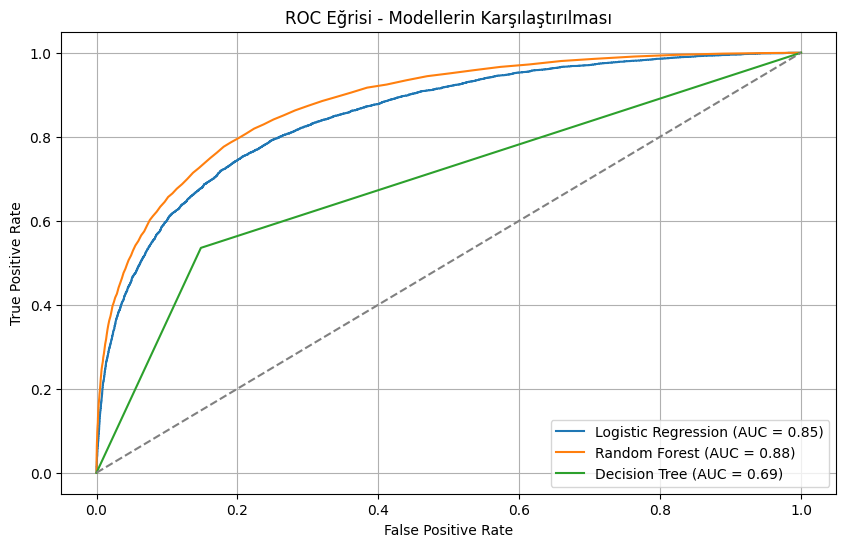

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Logistic Regression için
y_pred_proba_lr = model.predict_proba(X_test_scaled)[:, 1]  # model_lr yerine model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest için
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Decision Tree için
y_pred_proba_dt = model_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Grafik çizimi
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi - Modellerin Karşılaştırılması')
plt.legend(loc='lower right')
plt.grid()
plt.show()


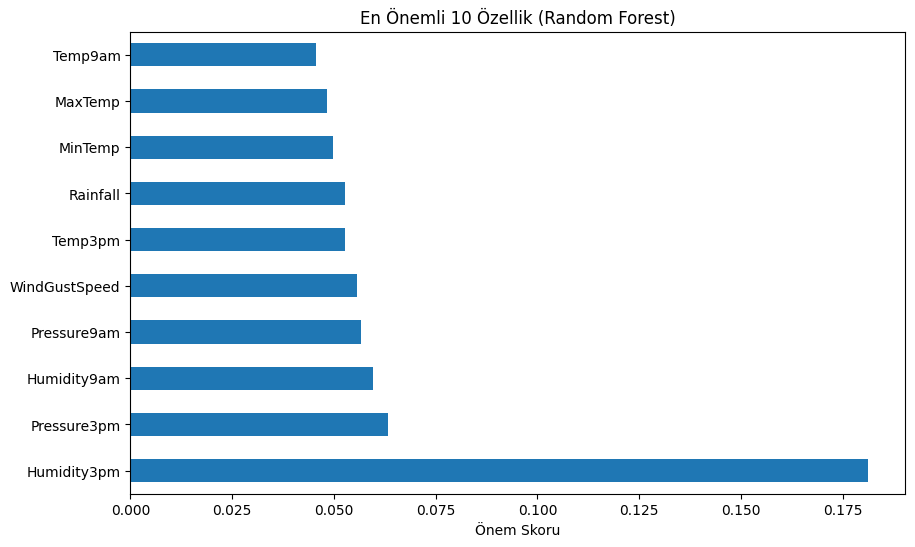

In [31]:
import pandas as pd

# Random Forest için
importances = model_rf.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp[:10].plot(kind='barh')
plt.title('En Önemli 10 Özellik (Random Forest)')
plt.xlabel('Önem Skoru')
plt.show()



Random Forest, ağaç temelli bir model olduğu için her bir özelliğin (feature) karar verme sürecine katkısını hesaplayabiliyor.
Her ağaçta dallanma sırasında hangi özelliğin ne kadar bilgi kazandırdığını ölçüyor. Bu sayede, modelin hangi değişkenlere daha çok dayandığını çıkarabiliyoruz.

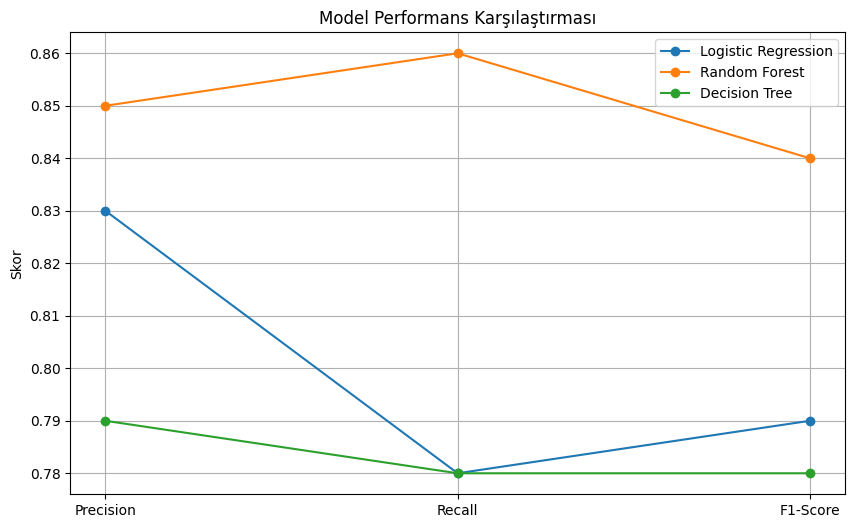

In [32]:
import matplotlib.pyplot as plt

# Modellerin sonuçları (örnek değerler, senin çıktılara göre doldur!)
metrics = {
    'Logistic Regression': [0.83, 0.78, 0.79],
    'Random Forest': [0.85, 0.86, 0.84],
    'Decision Tree': [0.79, 0.78, 0.78]
}

labels = ['Precision', 'Recall', 'F1-Score']
x = range(len(labels))

plt.figure(figsize=(10,6))

for model, scores in metrics.items():
    plt.plot(x, scores, marker='o', label=model)

plt.xticks(x, labels)
plt.ylabel('Skor')
plt.title('Model Performans Karşılaştırması')
plt.legend()
plt.grid(True)
plt.show()
